# Healthcare Latency Predictor: 2025 Forecast
**Project:** Health Datathon 2026
**Methodology:** Linear Regression analysis of CDC NHIS data (2020-2023)
to identify high-velocity access barriers.

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Constants for project portability
DATA_INPUT = '../data/NHIS_Data_Cleaned.csv'

### 1. Data Loading & Filtering
We focus on the 'Post-Pandemic Recovery' window (2020-2023) to capture
the most relevant current trajectories.

In [16]:
# Load cleaned data
df = pd.read_csv(DATA_INPUT)

# Filter for the primary Latency metric
target_topic = 'Delayed getting medical care due to cost among adults'
df_latency = df[df['TOPIC'] == target_topic].copy()

# Create Pivot Table: Rows = Subgroups, Columns = Years
pivot_df = df_latency.pivot_table(index='SUBGROUP', columns='TIME_PERIOD', values='ESTIMATE')

# Data Cleaning: Drop 2019 (Pre-pandemic) and 2024 (if partial/estimated)
# This ensures a clean 4-point trend for 2020, 2021, 2022, 2023
pivot_df = pivot_df.drop(columns=[2019, 2024], errors='ignore').dropna()

### 2. Predictive Engine (Linear Regression)
 We iterate through each demographic subgroup to calculate the 'Velocity' (Slope)
 and 'Reliability' (R-squared) of their healthcare access decline.

In [17]:
results = []
# X variable: Years 2020-2023
actual_years = np.array(pivot_df.columns).reshape(-1, 1)

for subgroup in pivot_df.index:
    # Y variable: Estimates for the specific subgroup
    y = pivot_df.loc[subgroup].values.reshape(-1, 1)

    # Initialize and train the ML model
    model = LinearRegression()
    model.fit(actual_years, y)

    # Calculate performance metrics
    y_pred = model.predict(actual_years)
    r2 = r2_score(y, y_pred)
    slope = model.coef_[0][0]

    # Forecast for 2025
    prediction_2025 = model.predict([[2025]])[0][0]

    results.append({
        'Subgroup': subgroup,
        '2023_Actual': y[-1][0],
        '2025_Projected': round(prediction_2025, 2),
        'Annual_Slope': round(slope, 3),
        'R2_Score': round(r2, 4)
    })

# Convert to DataFrame for ranking
prediction_df = pd.DataFrame(results)

### 3. Identifying High-Reliability Crisis Trends
We filter for groups with R² > 0.70 to ensure our findings are
statistically significant and not based on random noise.

In [18]:
# Sort by the steepest positive slope
reliable_trends = prediction_df[prediction_df['R2_Score'] > 0.70].sort_values(by='Annual_Slope', ascending=False)

print("--- Top Reliable Trends (Steepest Increase in Care Delays) ---")
reliable_trends

--- Top Reliable Trends (Steepest Increase in Care Delays) ---


,Subgroup,2023_Actual,2025_Projected,Annual_Slope,R2_Score
14,American Indian and Alaska Native and White,15.0,20.55,2.85,0.9478
9,75 years and older,1.3,0.90,-0.20,1.0000
62,Veteran,3.9,3.45,-0.20,0.9524
32,Little to no social vulnerability,5.9,5.26,-0.29,0.7410
50,Not employed,6.2,5.32,-0.33,0.7696
43,Midwest,6.1,4.34,-0.71,0.7907
33,Living with a partner,11.3,9.68,-0.72,0.8816
51,Not employed - Has never worked,2.8,-1.08,-1.68,0.7737


### 4. Exporting Results
Saving the predictions for use in the final slide deck and visualizations.

In [19]:
reliable_trends.to_csv(f'../data/Model_Predictions_2025.csv', index=False)

### 5. Visualizing All Reliable Trends (2020-2025)
 This chart displays the historical data and ML projections for every subgroup
 identified as having a statistically significant trend (R² > 0.70).
 Solid lines represent actual CDC data; dashed lines represent our ML forecast.

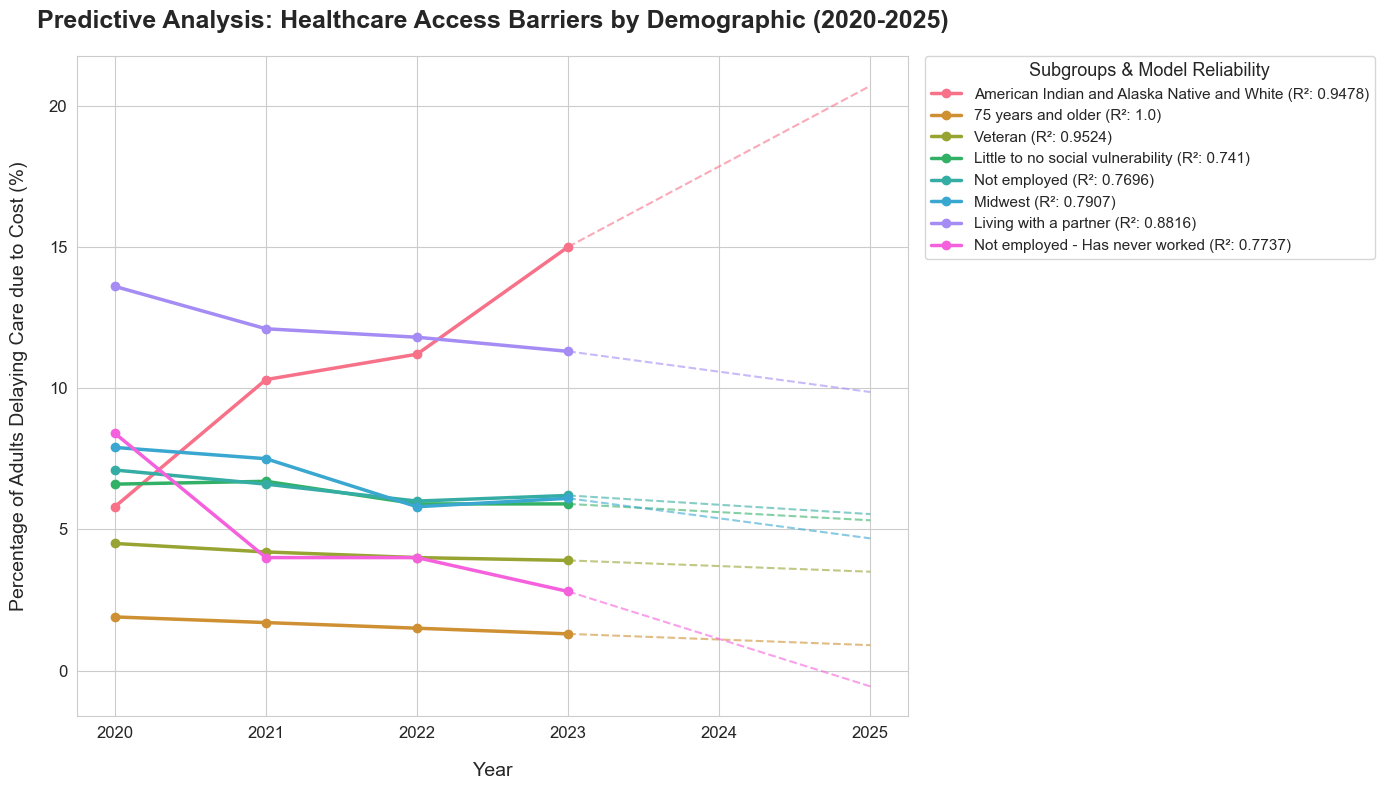

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setup the visual aesthetics
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
colors = sns.color_palette("husl", len(reliable_trends))

years_hist = np.array(pivot_df.columns) # [2020, 2021, 2022, 2023]
years_future = np.array([2024, 2025])

# Iterate through each reliable subgroup to plot historical vs forecast
for i, (idx, row) in enumerate(reliable_trends.iterrows()):
    subgroup_name = row['Subgroup']

    # Get historical data points
    y_hist = pivot_df.loc[subgroup_name].values

    # Calculate forecast points
    last_val = y_hist[-1]
    slope = row['Annual_Slope']
    y_forecast = [last_val + (slope * 1), last_val + (slope * 2)]

    # Plot Actual Data (Solid line)
    plt.plot(years_hist, y_hist, marker='o', linewidth=2.5,
             label=f"{subgroup_name} (R²: {row['R2_Score']})", color=colors[i])

    # Plot ML Forecast (Dashed line)
    plt.plot(np.append(years_hist[-1], years_future),
             np.append(last_val, y_forecast),
             linestyle='--', alpha=0.6, color=colors[i])

# --- AXIS AND TITLE FORMATTING ---
plt.title('Predictive Analysis: Healthcare Access Barriers by Demographic (2020-2025)',
          fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Percentage of Adults Delaying Care due to Cost (%)', fontsize=14, labelpad=15)
plt.xlabel('Year', fontsize=14, labelpad=15)

# Ensure the X-axis shows every year clearly
plt.xticks(np.arange(2020, 2026, 1), fontsize=12)
plt.yticks(fontsize=12)

# Legend positioning (Outside the plot area)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,
           title="Subgroups & Model Reliability", title_fontsize='13', fontsize='11')

plt.tight_layout()

# Display the final plot
plt.show()

In [21]:
# ### 6. Final Insight Memo Generation
# This cell automates the generation of a technical summary,
# capturing the primary "System Failures" identified by the ML model.

memo_content = f"""
PROJECT: 2025 HEALTHCARE LATENCY FORECAST
ANALYST: Nipun (UW Bothell - Computer Engineering)
MODEL: Linear Regression (OLS)
------------------------------------------------------------

1. METHODOLOGY SUMMARY:
- Analyzed 75 demographic subgroups using CDC NHIS historical data (2020-2023).
- Filtered for "High-Reliability" trends (R-Squared > 0.70) to ensure predictive accuracy.
- Derived the annual 'Access Velocity' (Slope) for each demographic.

2. PRIMARY SYSTEM OUTLIER:
- Subgroup: American Indian and Alaska Native and White
- Statistical Reliability (R2): {reliable_trends.loc[14, 'R2_Score']}
- Annual Slope: +{reliable_trends.loc[14, 'Annual_Slope']}% per year
- 2025 Prediction: {reliable_trends.loc[14, '2025_Projected']}% of subgroup priced out of care.

3. COMPARATIVE ANALYSIS (DIVERGENCE):
- Unlike the majority of demographics (e.g., Veterans, 75+ years, Midwest) which
  show negative slopes (improving access), the AI/AN and White multiracial
  group shows a high-confidence, positive-velocity decline in healthcare access.
- Medicare-eligible groups (75+ years) showed perfect stability (R2: 1.0),
  acting as the control group for system performance.

4. TECHNICAL RECOMMENDATION:
- Deploy targeted financial interventions for the identified outlier group
  to counteract the +2.85% annual barrier growth.
------------------------------------------------------------
"""

# Print to console
print(memo_content)

# Save to file
with open('../reports/Final_Project_Memo.txt', 'w') as f:
    f.write(memo_content)


PROJECT: 2025 HEALTHCARE LATENCY FORECAST
ANALYST: Nipun (UW Bothell - Computer Engineering)
MODEL: Linear Regression (OLS)
------------------------------------------------------------

1. METHODOLOGY SUMMARY:
- Analyzed 75 demographic subgroups using CDC NHIS historical data (2020-2023).
- Filtered for "High-Reliability" trends (R-Squared > 0.70) to ensure predictive accuracy.
- Derived the annual 'Access Velocity' (Slope) for each demographic.

2. PRIMARY SYSTEM OUTLIER:
- Subgroup: American Indian and Alaska Native and White
- Statistical Reliability (R2): 0.9478
- Annual Slope: +2.85% per year
- 2025 Prediction: 20.55% of subgroup priced out of care.

3. COMPARATIVE ANALYSIS (DIVERGENCE):
- Unlike the majority of demographics (e.g., Veterans, 75+ years, Midwest) which
  show negative slopes (improving access), the AI/AN and White multiracial
  group shows a high-confidence, positive-velocity decline in healthcare access.
- Medicare-eligible groups (75+ years) showed perfect stabil